In [1]:
# import
import os, sys, pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 8})
plt.rcParams["svg.fonttype"] = "none"

sys.path.extend([r'/home/lindenmp/research_projects/snaplab_tools'])
sys.path.extend([r'/home/lindenmp/research_projects/nctpy/src'])

from snaplab_tools.derivs import compute_acf
from nilearn.glm import first_level

In [2]:
def compute_timescales(timeseries, return_mean=True):
    n_parcels = timeseries.shape[1]
    n_subs = timeseries.shape[-1]
    print(n_subs, n_parcels)
    timescales = np.zeros((n_parcels, n_subs))
    for i in tqdm(np.arange(n_subs)):
        for j in np.arange(n_parcels):
            try:
                # time_series = signal.detrend(timeseries[:, j, i])
                _, timescales[j, i] = compute_acf(timeseries[:, j, i], nlags=20)
            except:
                timescales[j, i] = np.nan
    if return_mean:
        return np.nanmean(timescales, axis=1)
    else:
        return timescales

def get_task_events(ev_dir):
    task_events = pd.DataFrame(columns=['onset', 'duration', 'trial_type'])

    conditions = os.listdir(ev_dir)
    for condition in conditions:
        task_events_tmp = pd.DataFrame(columns=['onset', 'duration', 'trial_type'])

        try:
            ev_data = np.genfromtxt(os.path.join(ev_dir, condition))

            if ev_data.ndim == 1:
                task_events_tmp.loc[0, 'onset'] = ev_data[0]
                task_events_tmp.loc[0, 'duration'] = ev_data[1]
                task_events_tmp.loc[0, 'trial_type'] = condition.replace('.txt', '')

            elif ev_data.ndim == 2:
                for block in np.arange(ev_data.shape[0]):
                    task_events_tmp.loc[block, 'onset'] = ev_data[block, 0]
                    task_events_tmp.loc[block, 'duration'] = ev_data[block, 1]
                    task_events_tmp.loc[block, 'trial_type'] = condition.replace('.txt', '')
        except:
            pass
        
        task_events = pd.concat((task_events, task_events_tmp), axis=0)

    task_events.reset_index(inplace=True, drop=True)    
    
    return task_events

def compute_autocorrelation_with_hrf(fmri_data, task_events, tr, mask=None):
    """
    Compute autocorrelation of fMRI data while accounting for task structure and HRF.
    
    Parameters:
    - fmri_data: 4D numpy array (x,y,z,time) or 2D array (voxels,time)
    - task_events: pandas DataFrame with task events (onset, duration, trial_type)
    - tr: repetition time (in seconds)
    - mask: binary mask for voxel selection (optional)
    
    Returns:
    - autocorrelation: array of autocorrelation values
    - residuals: residual time series after task+HRF modeling
    """
    
    # If input is 4D, reshape to 2D (voxels × time)
    if fmri_data.ndim == 4:
        original_shape = fmri_data.shape
        n_voxels = np.prod(original_shape[:3])
        n_timepoints = original_shape[3]
        fmri_data_2d = fmri_data.reshape((n_voxels, n_timepoints))
        
        # Apply mask if provided
        if mask is not None:
            mask = mask.reshape(-1)
            fmri_data_2d = fmri_data_2d[mask > 0, :]
    else:
        fmri_data_2d = fmri_data

    # Compute autocorrelation before any processing
    autocorr = []
    for voxel_ts in fmri_data_2d:
        standardized = (voxel_ts - np.mean(voxel_ts)) / np.std(voxel_ts)
        acf = np.correlate(standardized, standardized, mode='full')
        acf = acf[len(acf)//2:]
        acf = acf / acf[0]
        autocorr.append(acf)
    autocorr = np.array(autocorr)

    # Create design matrix with HRF convolution
    frame_times = np.arange(fmri_data_2d.shape[1]) * tr
    design_matrix = first_level.make_first_level_design_matrix(
        frame_times,
        events=task_events,
        hrf_model='glover + derivative + dispersion',
        drift_model='cosine',
        high_pass=0.01
    )
    
    # detrend data
    # for i in np.arange(fmri_data_2d.shape[0]):
        # fmri_data_2d[i, :] = signal.detrend(fmri_data_2d[i, :])
    
    # Fit GLM to remove task effects
    X = design_matrix.values
    beta = np.dot(np.linalg.pinv(X), fmri_data_2d.T)
    predicted = np.dot(X, beta)
    residuals = fmri_data_2d - predicted.T
    
    # Compute autocorrelation on residuals
    autocorr_resid = []
    zero_crossings = []
    for voxel_resid in residuals:
        standardized = (voxel_resid - np.mean(voxel_resid)) / np.std(voxel_resid)
        acf = np.correlate(standardized, standardized, mode='full')
        acf = acf[len(acf)//2:]  # Take only non-negative lags
        acf = acf / acf[0]  # Normalize
        autocorr_resid.append(acf)
        
        # Find first zero-crossing
        cross_idx = np.where(acf < 0)[0]
        zero_crossings.append(cross_idx[0] if len(cross_idx) > 0 else len(acf)-1)
    
    autocorr_resid = np.array(autocorr_resid)
    zero_crossings = np.array(zero_crossings)

    return autocorr, autocorr_resid, zero_crossings, residuals, design_matrix

def plot_autocorrelation_comparison(autocorr_before, autocorr_after, zero_crossings=None, max_lag=20):
    """Plot autocorrelation before and after task regression together."""
    mean_before = np.mean(autocorr_before, axis=0)
    std_before = np.std(autocorr_before, axis=0)
    
    mean_after = np.mean(autocorr_after, axis=0)
    std_after = np.std(autocorr_after, axis=0)
    
    plt.figure(figsize=(8, 4))
    
    # Plot autocorrelation comparison
    plt.subplot(1, 2, 1)
    lags = range(len(mean_before[:max_lag+1]))
    
    # Before regression
    plt.errorbar(x=lags, y=mean_before[:max_lag+1],
                 yerr=std_before[:max_lag+1],
                 fmt='-o', color='blue', alpha=0.7,
                 label='Before task regression')
    
    # After regression
    plt.errorbar(x=lags, y=mean_after[:max_lag+1],
                 yerr=std_after[:max_lag+1],
                 fmt='-o', color='red', alpha=0.7,
                 label='After task regression')
    
    plt.axhline(0, color='k', linestyle='--')
    plt.xlabel('Lag (TRs)')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation Before vs After Task Regression')
    plt.legend()
    plt.grid(True)
    
    # Plot zero-crossing distribution if provided
    if zero_crossings is not None:
        plt.subplot(1, 2, 2)
        plt.hist(zero_crossings, bins=np.linspace(0, max_lag, 21), 
                 edgecolor='k', color='red', alpha=0.7)
        plt.xlabel('First Zero-Crossing Lag (TRs)')
        plt.ylabel('Number of Voxels')
        plt.title('Post-Regression Zero-Crossing Distribution')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## Setup

In [3]:
# directory where data is stored
indir = '/home/lindenmp/research_projects/nct_xr/data/int_deflections'
which_data = 'HCP_YA'
# which_data = 'HCP_D'
outdir = '/home/lindenmp/research_projects/nct_xr/results/int_deflections/{0}'.format(which_data.replace('_', ''))

atlas = 'Schaefer4007'
if atlas == 'Schaefer4007':
    n_parcels = 400
    n_nodes = 400
elif atlas == 'Schaefer2007':
    n_parcels = 200
    n_nodes = 200
elif atlas == 'Schaefer1007':
    n_parcels = 100
    n_nodes = 100
    
if which_data == 'HCP_YA':
    tr = 0.720
    tasks = ['tfMRI_EMOTION_LR', 'tfMRI_GAMBLING_LR', 'tfMRI_LANGUAGE_LR', 'tfMRI_RELATIONAL_LR', 'tfMRI_SOCIAL_LR', 'tfMRI_WM_LR']
    # tasks = ['tfMRI_WM_LR', ]

elif which_data == 'HCP_D':
    tr = 0.800
    tasks = ['tfMRI_CARIT_PA', 'tfMRI_EMOTION_PA', 'tfMRI_GUESSING_PA']

# Load data

In [4]:
subjectids = np.loadtxt(os.path.join(indir, '{0}_{1}_subjids.txt'.format(which_data.replace('_', ''), atlas)), dtype=str)
n_subs = len(subjectids)
print(n_subs)

955


In [5]:
rest_ts = np.load(os.path.join(indir, '{0}_{1}_rsts.npy'.format(which_data.replace('_', ''), atlas)))
rest_ts = rest_ts[:, :, 0, :]
rest_timescales = compute_timescales(rest_ts, return_mean=False).T

which_task = 'rfMRIREST1LR'
np.save(os.path.join(outdir, '{0}_{1}_{2}_timescales.npy'.format(which_data.replace('_', ''), atlas, which_task)), rest_timescales)

print(rest_ts.shape, rest_timescales.shape)

955 400


100%|██████████| 955/955 [00:23<00:00, 40.65it/s]

(1200, 400, 955) (955, 400)


In [6]:
from nilearn.plotting import plot_design_matrix

tfMRI_EMOTION_LR


  0%|          | 0/955 [00:00<?, ?it/s]

['fear' 'neut']


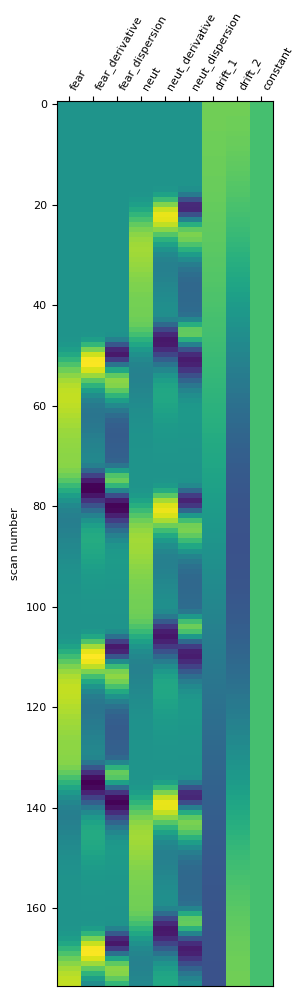

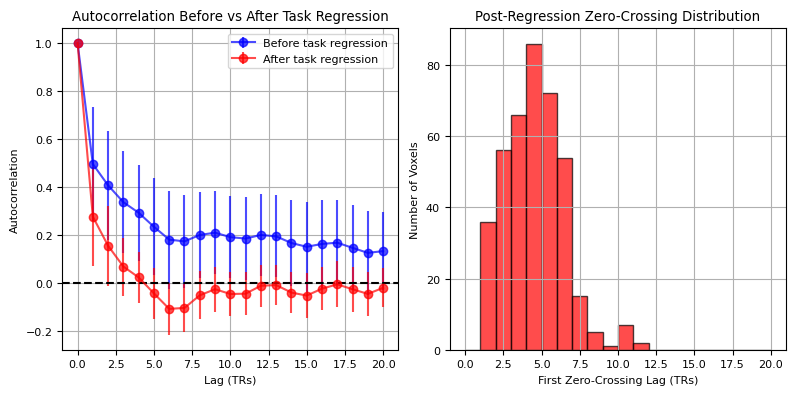

100%|██████████| 955/955 [00:56<00:00, 16.91it/s]


tfMRI_GAMBLING_LR


  0%|          | 0/955 [00:00<?, ?it/s]

['loss' 'win']


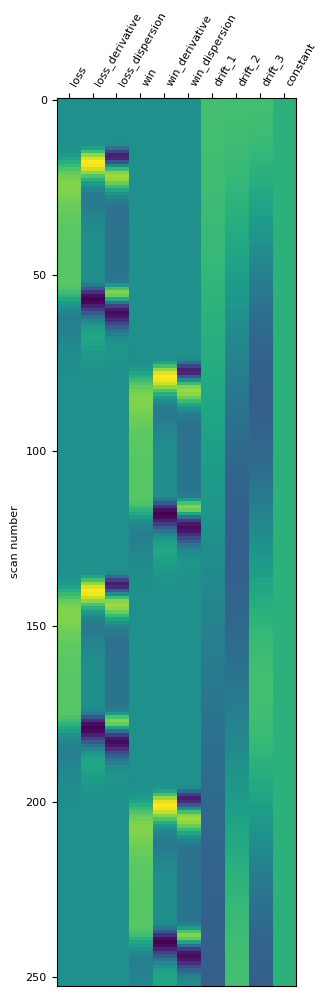

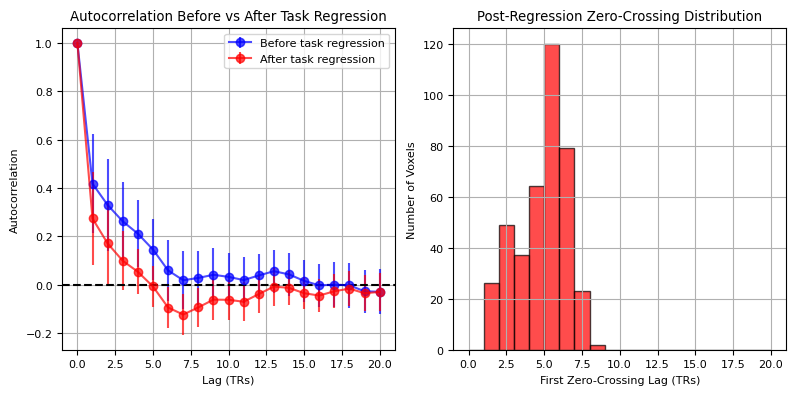

100%|██████████| 955/955 [01:09<00:00, 13.76it/s]


tfMRI_LANGUAGE_LR


  0%|          | 0/955 [00:00<?, ?it/s]

['math' 'story']


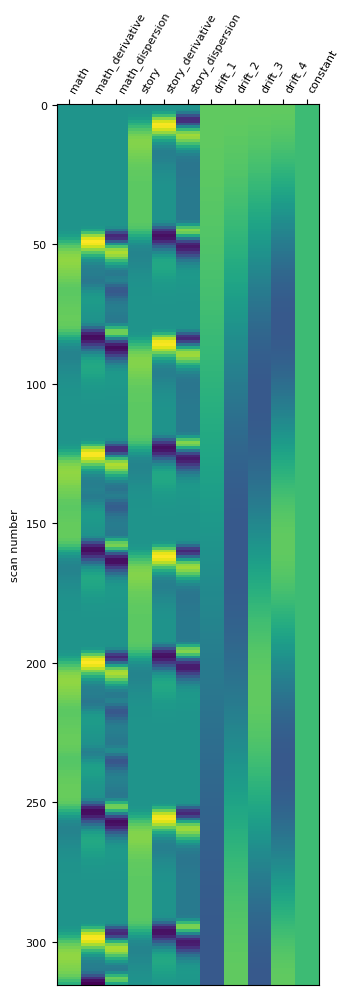

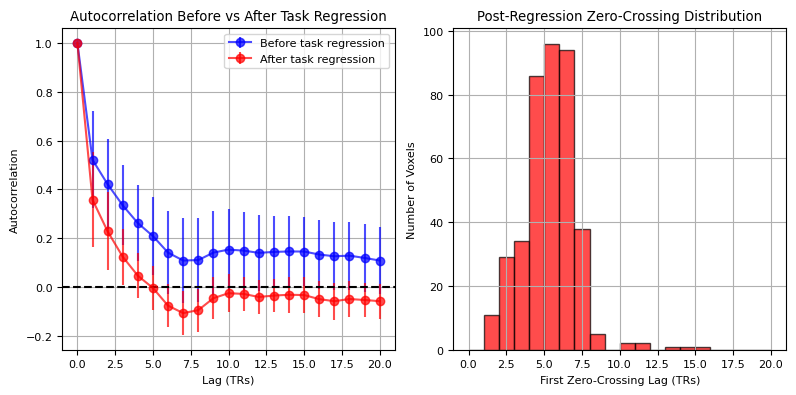

100%|██████████| 955/955 [01:19<00:00, 11.94it/s]


tfMRI_RELATIONAL_LR


  0%|          | 0/955 [00:00<?, ?it/s]

['match' 'relation']


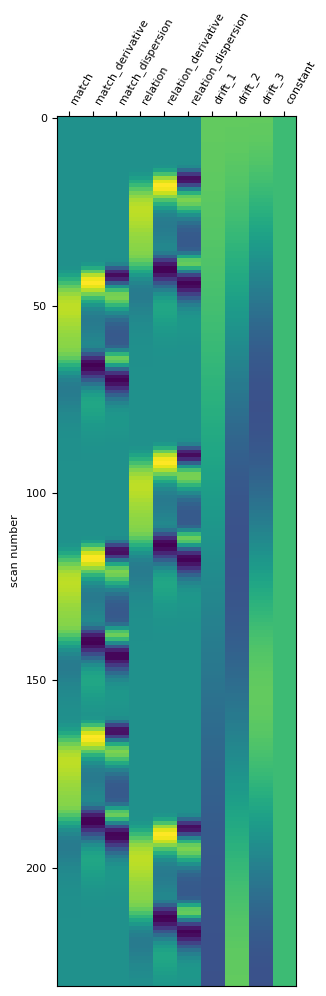

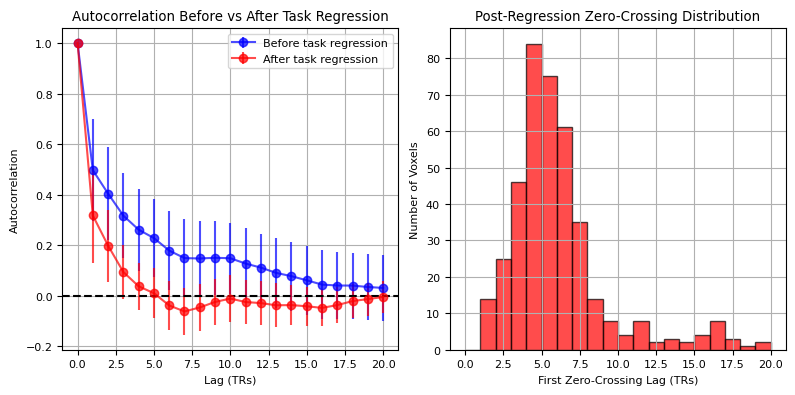

100%|██████████| 955/955 [01:03<00:00, 14.93it/s]


tfMRI_SOCIAL_LR


  0%|          | 0/955 [00:00<?, ?it/s]

['mental' 'rnd']


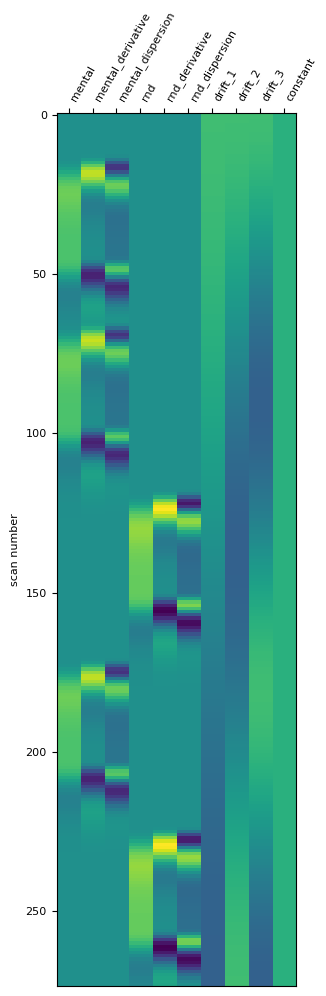

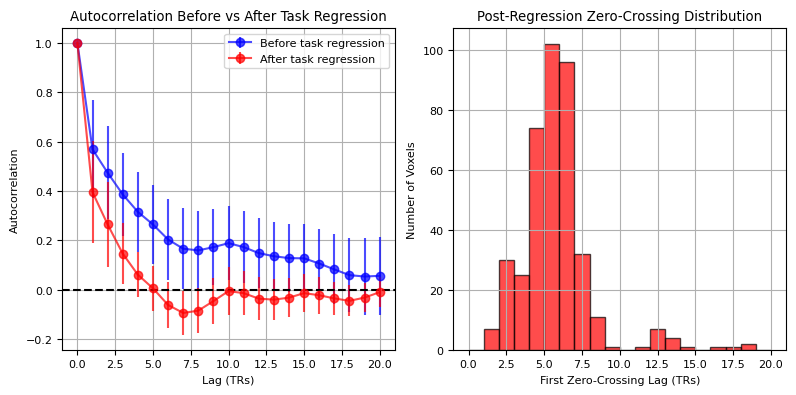

100%|██████████| 955/955 [01:12<00:00, 13.19it/s]


tfMRI_WM_LR


  0%|          | 0/955 [00:00<?, ?it/s]

['0bk' '2bk']


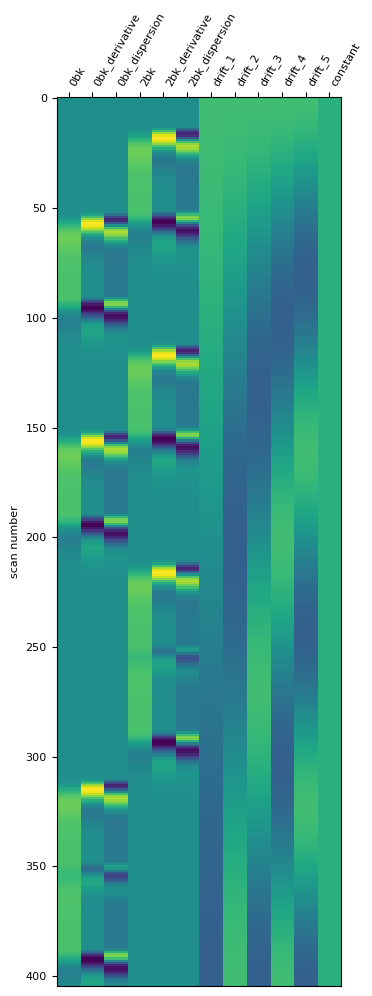

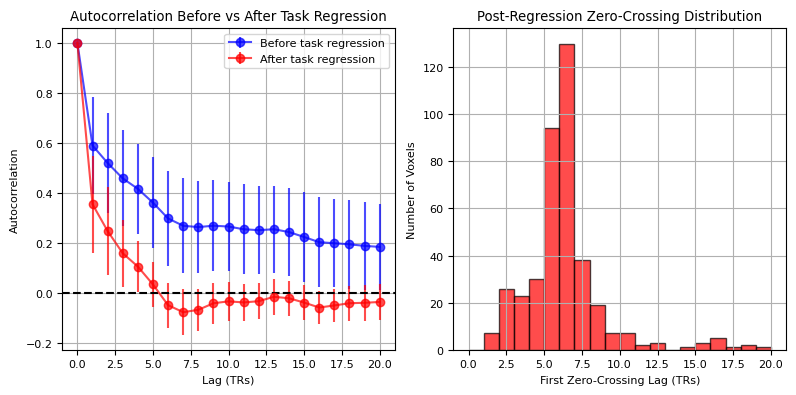

100%|██████████| 955/955 [01:30<00:00, 10.51it/s]


In [7]:
for which_task in tasks:
    print(which_task)
    if which_task == 'tfMRI_EMOTION_LR':
        contrasts_list = ['fear', 'neut']
    elif which_task == 'tfMRI_GAMBLING_LR':
        contrasts_list = ['win', 'loss']
    elif which_task == 'tfMRI_LANGUAGE_LR':
        contrasts_list = ['math', 'story']
    elif which_task == 'tfMRI_RELATIONAL_LR':
        contrasts_list = ['match', 'relation']
    elif which_task == 'tfMRI_SOCIAL_LR':
        contrasts_list = ['mental', 'rnd']
    elif which_task == 'tfMRI_WM_LR' or which_task == 'tfMRI_WM_RL':
        contrasts_list = ['0bk', '2bk']

    task_ts = np.load(os.path.join(indir, '{0}_{1}_taskts-{2}.npy'.format(which_data.replace('_', ''), atlas, which_task.replace('_', ''))))
    task_ts = task_ts[:, :, 0, :]

    df_task_events_summary = pd.DataFrame(index=subjectids)
    task_timescales = np.zeros((n_subs, n_parcels))
    subject_filter = np.zeros(n_subs).astype(bool)
    contrasts = dict.fromkeys(contrasts_list)
    for contrast in contrasts_list:
        contrasts[contrast] = []

    for i in tqdm(np.arange(n_subs)):
        subjid = subjectids[i]
        if which_data == 'HCP_YA':
            ev_dir = os.path.join('/mnt/storage_ssd_raid/research_data/HCP_YA/HCP_1200', str(subjid), 'MNINonLinear', 'Results', which_task, 'EVs')
        elif which_data == 'HCP_D':
            subjid_converted = subjid.split('-')[1].replace('V1MR', '_V1_MR')
            ev_dir = os.path.join('/mnt/storage_ssd_raid/research_data/HCP_D/processed', subjid_converted, 'MNINonLinear', 'Results', which_task, 'EVs')
        
        try:
            task_events = get_task_events(ev_dir)
            if which_task == 'tfMRI_CARIT_PA':
                for j in np.arange(task_events.shape[0]):
                    if 'nogo' in task_events.loc[j, 'trial_type']:
                        task_events.loc[j, 'trial_type'] = 'nogo'
                        
                retain_idx = task_events['trial_type'] != 'miss'
                task_events = task_events.loc[retain_idx, :]
            elif which_task == 'tfMRI_WM_LR' or which_task == 'tfMRI_WM_RL':
                for j in np.arange(task_events.shape[0]):
                    if '0bk' in task_events.loc[j, 'trial_type']:
                        task_events.loc[j, 'trial_type'] = '0bk'
                    elif '2bk' in task_events.loc[j, 'trial_type']:
                        task_events.loc[j, 'trial_type'] = '2bk'
                
            # unique_events = np.unique(task_events['trial_type'])
            for event in contrasts_list:
                df_task_events_summary.loc[subjid, event] = np.sum(task_events['trial_type'] == event)

            fmri_data = task_ts[:, :, i]
            autocorr, autocorr_resid, task_timescales[i, :], residuals, design_matrix = compute_autocorrelation_with_hrf(fmri_data.T, task_events, tr)
            
            # compute contrasts    
            beta = np.dot(np.linalg.pinv(design_matrix.values), fmri_data)
            for contrast in contrasts_list:
                contrast_idx = list(design_matrix.columns).index(contrast)
                contrasts[contrast].append(beta[contrast_idx, :])
                
            if i == 0:
                print(np.unique(task_events['trial_type']))
                plot_design_matrix(design_matrix)
                plot_autocorrelation_comparison(autocorr, autocorr_resid, task_timescales[i, :])
        except:
            subject_filter[i] = True
            
    for contrast in contrasts_list:
        contrasts[contrast] = np.asarray(contrasts[contrast])

    np.save(os.path.join(outdir, '{0}_{1}_{2}_timescales.npy'.format(which_data.replace('_', ''), atlas, which_task.replace('_', ''))), task_timescales)
    with open(os.path.join(outdir, '{0}_{1}_{2}_contrasts.pkl'.format(which_data.replace('_', ''), atlas, which_task.replace('_', ''))), 'wb') as f:
        pickle.dump(contrasts, f)
    if np.any(subject_filter):
        np.save(os.path.join(outdir, '{0}_{1}_{2}_subjectfilter.npy'.format(which_data.replace('_', ''), atlas, which_task.replace('_', ''))), subject_filter)